# Chicago PM2.5 AQI Forecasting using SARIMA which is part of ARIMA model



# 1. Importing required packages and loading PM2.5 Data

In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from statsmodels.tsa.arima_model import ARIMA

Loading the historical data from the city of chicago air quality index 

In [2]:
data = pd.read_csv("./AQI2014-2020.csv", na_values = "NaN", index_col=[0],parse_dates=['Date'], date_parser = pd.to_datetime )


In [3]:
data.columns

Index(['Site ID', 'Daily Mean PM2.5 Concentration', 'UNITS', 'DAILY_AQI_VALUE',
       'Site Name', 'STATE_CODE', 'STATE', 'COUNTY', 'SITE_LATITUDE',
       'SITE_LONGITUDE', 'POC'],
      dtype='object')

In the time series data evaluation we only focus on the date and the air quality index value. The rest of the columns are dropped from the dataset as they do not add value to the problem statement 

In [4]:
data.drop(['Site ID', 'Daily Mean PM2.5 Concentration', 'UNITS',
       'Site Name', 'STATE_CODE', 'STATE', 'COUNTY', 'SITE_LATITUDE',
       'SITE_LONGITUDE', 'POC'], axis=1, inplace=True)

In [5]:
data.rename(columns={'DAILY_AQI_VALUE': 'AQI'}, inplace=True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20545 entries, 2014-01-01 to 2020-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   AQI     20545 non-null  int64
dtypes: int64(1)
memory usage: 321.0 KB


Using monthly average for our plot analysis 

In [7]:
# MS groups data in months
data = data['AQI'].resample('MS').mean()

# The term bfill means that we use the value before filling in missing values
data = data.fillna(data.bfill())

print(data)

Date
2014-01-01    32.704663
2014-02-01    42.173913
2014-03-01    44.233333
2014-04-01    41.666667
2014-05-01    40.704301
                ...    
2020-08-01    38.084507
2020-09-01    36.601504
2020-10-01    32.000000
2020-11-01    34.023810
2020-12-01    36.729323
Freq: MS, Name: AQI, Length: 84, dtype: float64


Visualize the monthly averages  

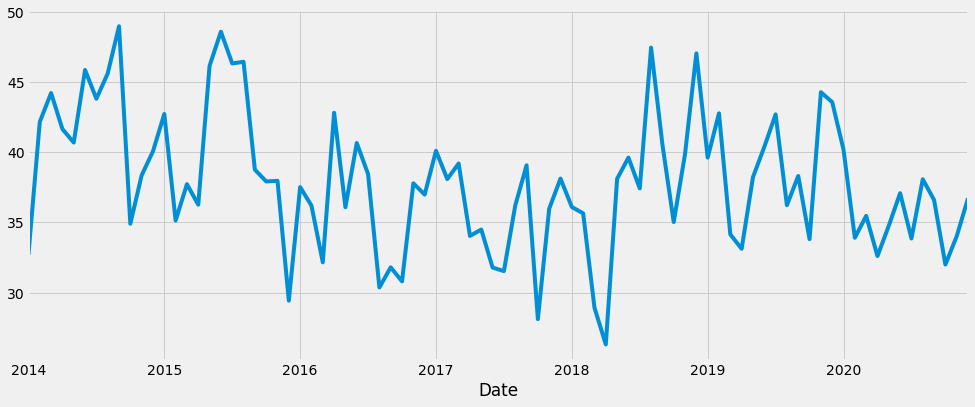

In [8]:
data.plot(figsize=(15, 6))
plt.show()

# 2. ARIMA Model (Parameter Selection
Grid Search is being use to iteratively explore different combinations of parameters

In [9]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, d and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

Go through combinations of parameters and SARIMAX function from statsmodels to fit the corresponding Seasonal ARIMA model and print out AIC score.
The lowest AIC being the best

In [10]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:842.7092831922778
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:656.9221273327363
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:463.0427894966416
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:373.0149747096587
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:468.5263997986241
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:442.2652685234976
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:388.35501638352906
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:373.30964057828817
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:739.0403196431579
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:585.806010335059
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:451.64607004607143
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:357.87550433351737
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:465.56086439096515
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:452.83425049687185
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:380.4852821498408
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:361.27543523559467
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:503.93021170301574
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:431.0782387087191
ARI

# 3. Fitting the ARIMA model
Plug the optimal parameters from the gridsearch into model

In [14]:
mod = sm.tsa.statespace.SARIMAX(data,
                                order=(1,1,1),
                                seasonal_order=(1,1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3694      0.198      1.865      0.062      -0.019       0.758
ma.L1         -1.1493      0.163     -7.058      0.000      -1.468      -0.830
ar.S.L12      -0.1878      0.205     -0.918      0.359      -0.589       0.213
ma.S.L12      -0.7338      0.384     -1.912      0.056      -1.486       0.018
sigma2        16.4027      8.053      2.037      0.042       0.619      32.186


Display the model diagnostic to determine the distribution of residuals 


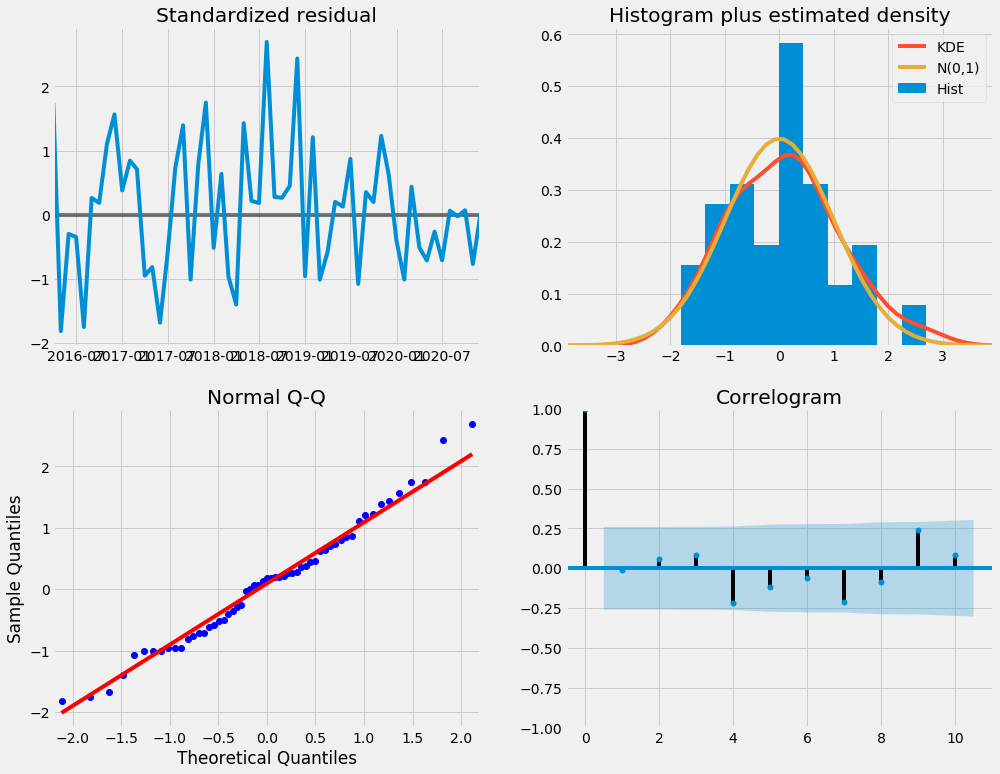

In [15]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

# 4. Validating Forecasts

In [16]:
#initiating forecasting starting date
pred = results.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=False)
pred_ci = pred.conf_int()

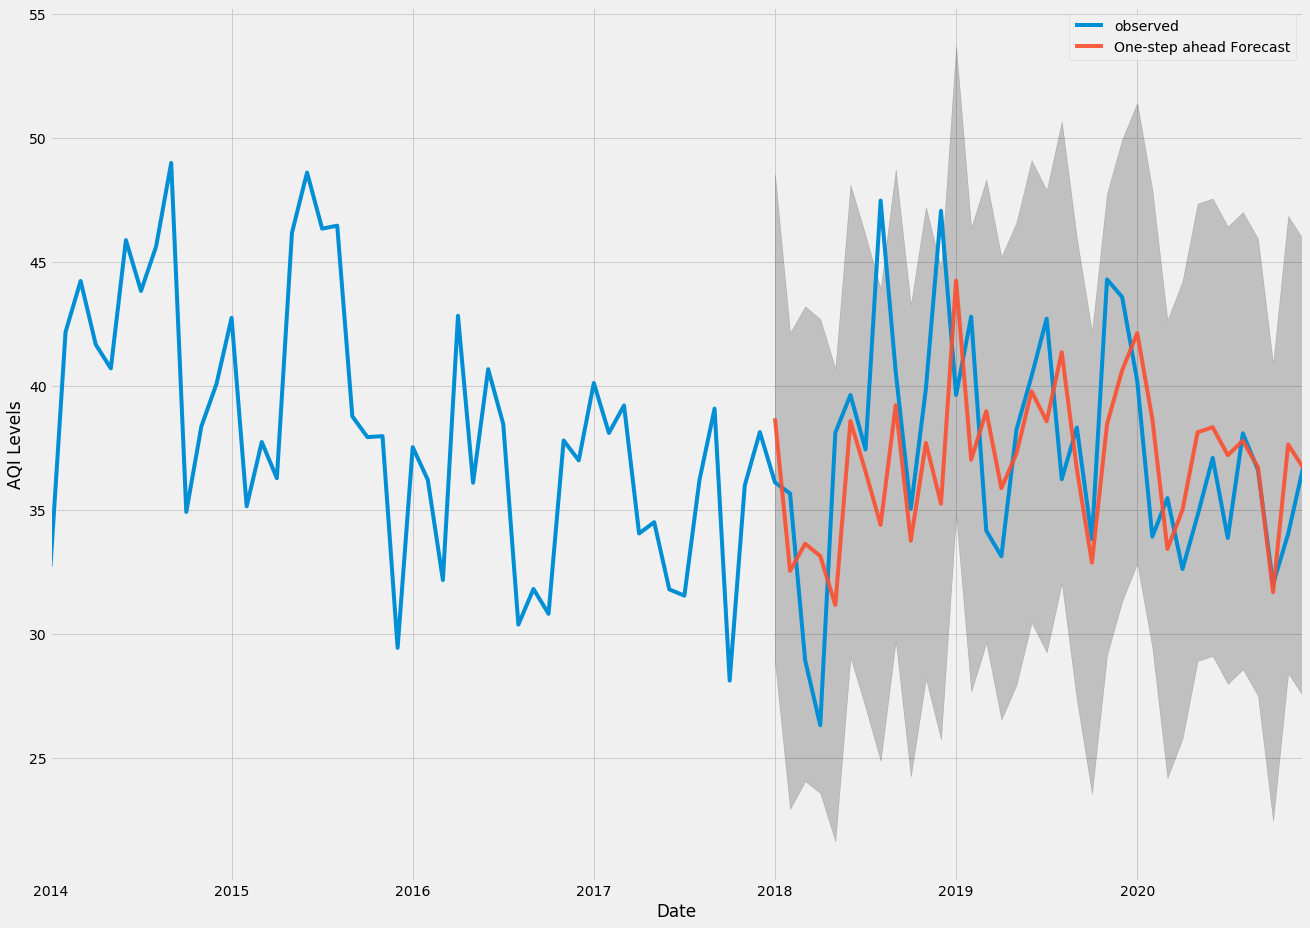

In [17]:
#Plot real vurses forecasted AQI values of PM2.5 and using slicing to zoom into the forecasted area of plot   
ax = data['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9,figsize=(20, 15))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('AQI Levels')
plt.legend()

plt.show()

Using Mean Square error to detect the accuracy of the forecast

In [18]:
y_forecasted = pred.predicted_mean
y_truth = data['2014-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 19.58


In [19]:
#Computing the start of dynamic forecast and confidence interval
pred_dynamic = results.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

Plotting the observed and forecasted values of the time series 

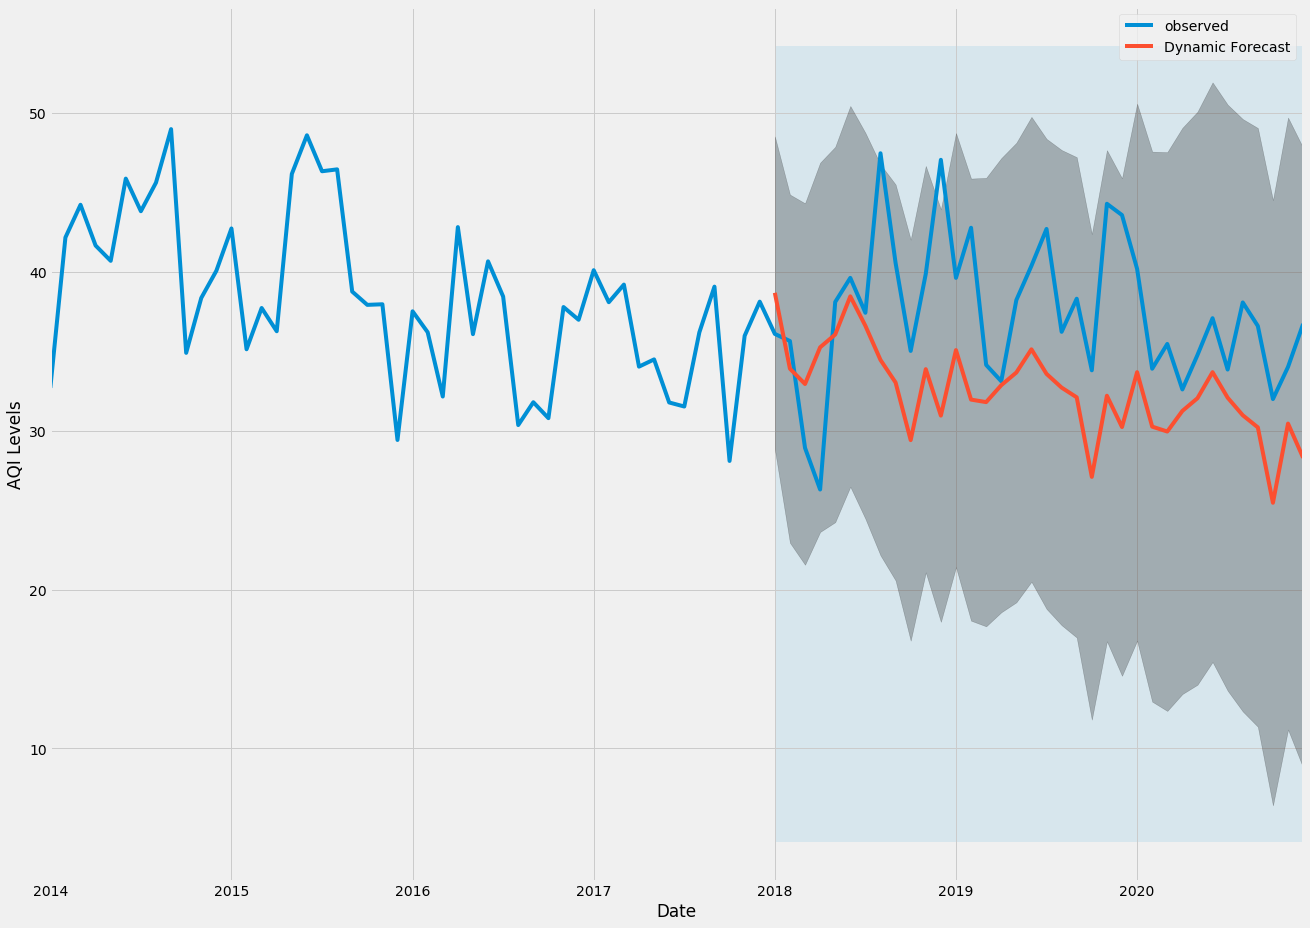

In [20]:
ax = data['2014':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2018-01-01'), data.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('AQI Levels')

plt.legend()
plt.show()

In [21]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = data['2018-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 46.88


# 5. Producing specified forecast

In [22]:
# Get forecast 24 steps ahead in future(2 years)
pred_uc = results.get_forecast(steps=24)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

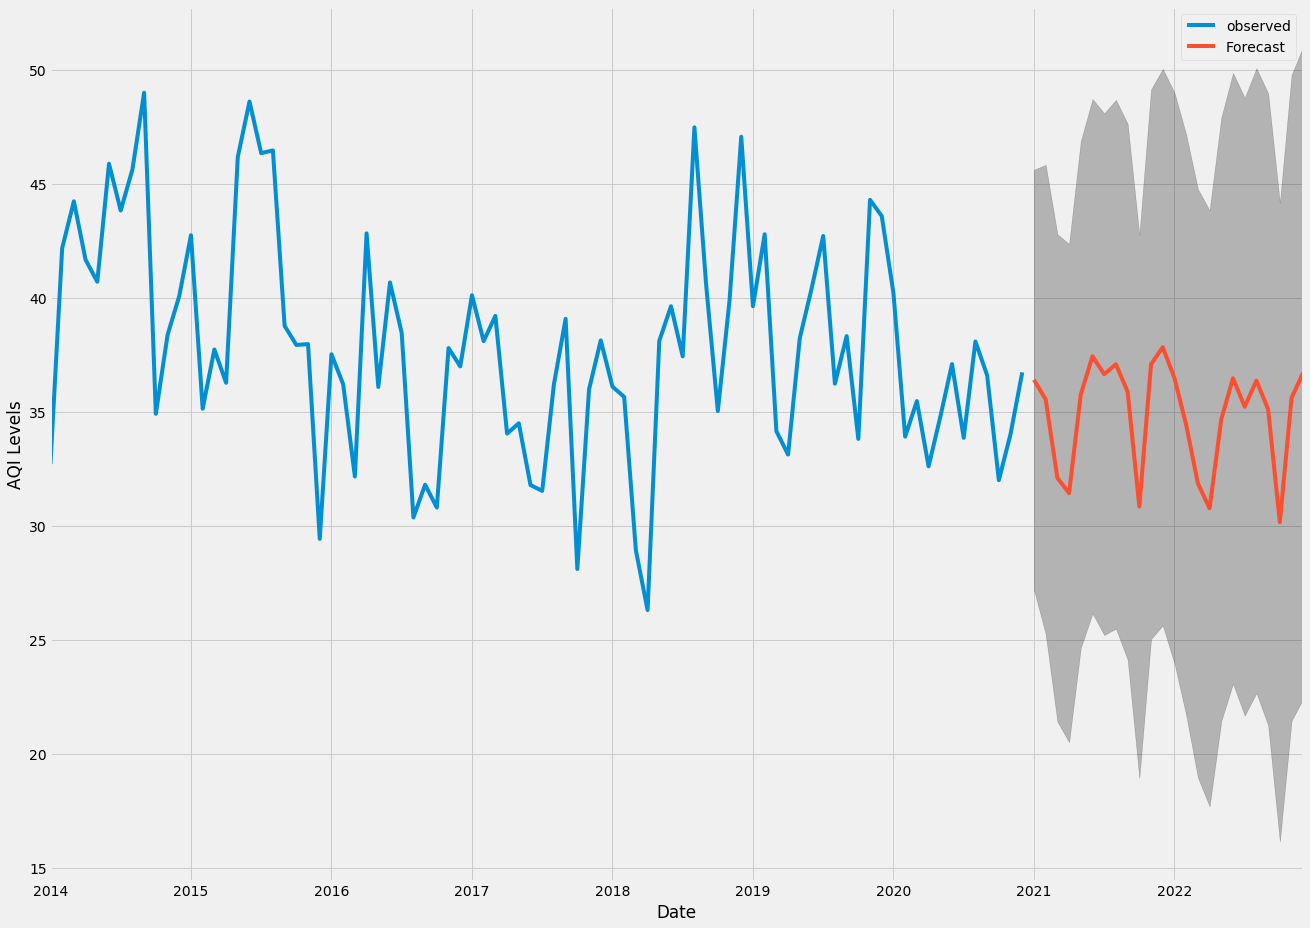

In [23]:
#plot the the time series and forecast for future values 
ax = data.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('AQI Levels')

plt.legend()
plt.show()